In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast, RobertaForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    TrainerCallback, EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\anaconda3\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [12]:
# 📂 Load dataset
df = pd.read_csv("./dataset.csv")
df.columns = df.columns.str.strip()
df = df.iloc[1:]
df = df[df['Level'].isin([0, 1, 2, 3])]
df['Level'] = df['Level'].astype(int)
df.rename(columns={'Level': 'labels'}, inplace=True)

In [3]:
# 🧪 Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# 📤 Convert to HF Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# 🔠 Tokenization
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize_function(example):
    return tokenizer(example["Response"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

C:\ProgramData\anaconda3\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [4]:
# 📦 Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [5]:
# 🧠 Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# 📊 Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }


In [7]:
# 🧩 Accuracy logging callback
class AccuracyTrackerCallback(TrainerCallback):
    def __init__(self, trainer_ref):
        self.trainer = trainer_ref
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_output = self.trainer.predict(self.trainer.train_dataset)
        train_preds = train_output.predictions.argmax(axis=1)
        train_labels = train_output.label_ids
        train_acc = accuracy_score(train_labels, train_preds)
        self.train_accuracies.append(train_acc)

        eval_output = self.trainer.predict(self.trainer.eval_dataset)
        eval_preds = eval_output.predictions.argmax(axis=1)
        eval_labels = eval_output.label_ids
        eval_acc = accuracy_score(eval_labels, eval_preds)
        self.eval_accuracies.append(eval_acc)

        print(f"\n📊 Epoch {state.epoch:.0f} → Train Acc: {train_acc:.4f} | Val Acc: {eval_acc:.4f}")

In [8]:
# 📦 Initialize trainer
accuracy_logger = AccuracyTrackerCallback(None)


In [9]:

# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./roberta_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./roberta_logs",
    logging_steps=50,
    save_total_limit=2
)


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        accuracy_logger,
        EarlyStoppingCallback(early_stopping_patience=7)
    ]
)

accuracy_logger.trainer = trainer

In [16]:
# 🚀 Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.071700,0.354179,0.946550,0.950214,0.935137,0.940999
2,0.066600,0.394980,0.944606,0.945528,0.937150,0.939653
3,0.134400,0.430082,0.931001,0.928334,0.924519,0.924222
4,0.092400,0.280849,0.952381,0.951879,0.944744,0.948022
5,0.058700,0.401095,0.953353,0.957328,0.944349,0.949781
6,0.083300,0.406022,0.946550,0.942226,0.943185,0.942514
7,0.001700,0.359587,0.955296,0.951464,0.954504,0.952495
8,0.000500,0.368369,0.960155,0.961487,0.954935,0.957809
9,0.001600,0.437174,0.951409,0.952724,0.944431,0.948185
10,0.028100,0.441386,0.947522,0.946640,0.939339,0.942547



📊 Epoch 1 → Train Acc: 0.9917 | Val Acc: 0.9466

📊 Epoch 2 → Train Acc: 0.9927 | Val Acc: 0.9446

📊 Epoch 3 → Train Acc: 0.9939 | Val Acc: 0.9310

📊 Epoch 4 → Train Acc: 0.9981 | Val Acc: 0.9524

📊 Epoch 5 → Train Acc: 0.9990 | Val Acc: 0.9534

📊 Epoch 6 → Train Acc: 0.9978 | Val Acc: 0.9466

📊 Epoch 7 → Train Acc: 0.9998 | Val Acc: 0.9553

📊 Epoch 8 → Train Acc: 0.9998 | Val Acc: 0.9602

📊 Epoch 9 → Train Acc: 0.9998 | Val Acc: 0.9514

📊 Epoch 10 → Train Acc: 0.9995 | Val Acc: 0.9475

📊 Epoch 11 → Train Acc: 0.9998 | Val Acc: 0.9495

📊 Epoch 12 → Train Acc: 1.0000 | Val Acc: 0.9563

📊 Epoch 13 → Train Acc: 1.0000 | Val Acc: 0.9582

📊 Epoch 14 → Train Acc: 1.0000 | Val Acc: 0.9572

📊 Epoch 15 → Train Acc: 0.9993 | Val Acc: 0.9514


TrainOutput(global_step=7710, training_loss=0.034452030524122185, metrics={'train_runtime': 3554.8767, 'train_samples_per_second': 23.134, 'train_steps_per_second': 2.892, 'total_flos': 784508476644672.0, 'train_loss': 0.034452030524122185, 'epoch': 15.0})

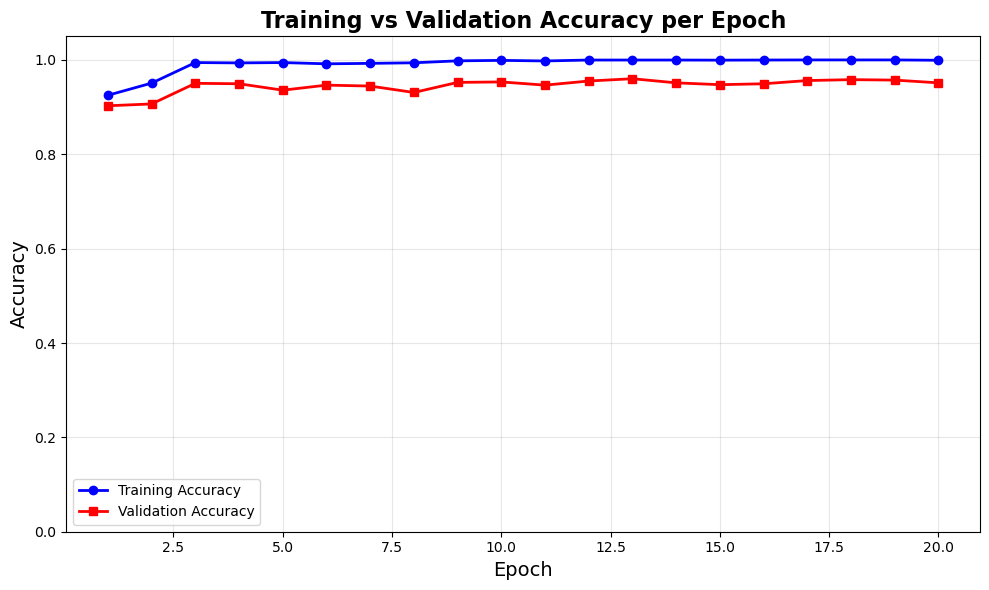

In [17]:
# 📈 Plot Training vs Validation Accuracy
train_accs = accuracy_logger.train_accuracies
val_accs = accuracy_logger.eval_accuracies
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label="Training Accuracy", marker='o', linewidth=2, color='blue')
plt.plot(epochs, val_accs, label="Validation Accuracy", marker='s', linewidth=2, color='red')

plt.title("Training vs Validation Accuracy per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


🔍 Classification Report:

              precision    recall  f1-score   support

     Level 0     0.9680    0.9737    0.9708       342
     Level 1     0.9659    0.9474    0.9565       209
     Level 2     0.9727    0.9128    0.9418       195
     Level 3     0.9394    0.9859    0.9621       283

    accuracy                         0.9602      1029
   macro avg     0.9615    0.9549    0.9578      1029
weighted avg     0.9606    0.9602    0.9600      1029


📊 Final Test Accuracy: 0.9602


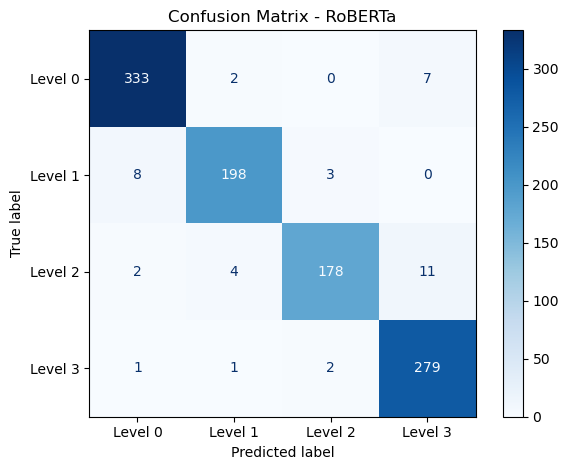

In [18]:
# 🔍 Final Evaluation
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Level 0", "Level 1", "Level 2", "Level 3"], digits=4))
print(f"\n📊 Final Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Level 0", "Level 1", "Level 2", "Level 3"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - RoBERTa")
plt.tight_layout()
plt.show()
